# VAD script
cut initial silence segments in dataset mel-spectrograms to speedup alignment formation during tacotron training

In [1]:
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [4]:
def find_cut_point(mel, confidence=0.97) : 
    energy = mel.sum(axis=0)
    dif = np.diff(energy)
    spikes = np.argwhere(np.where(dif>40, 100,0)) - 1
    if len(spikes.flatten()) <= 0 : 
        return None
    else : 
        mode = np.sqrt(np.sum(mel**2, axis=0))[None]
        self_cor = mel.T @ mel / (mode.T * mode)
        
        target_cut_off = 0  
        
        for spike in spikes.flatten() : 
            uniformity = np.mean(self_cor[:spike, :spike])
#             print(f'u : {uniformity}')
            if uniformity < confidence : 
                break
            else : 
                target_cut_off = spike
        
        return target_cut_off
    
    
def load_mel(path) : 
    return np.load(path).T

def save_mel(mel, path) : 
    np.save(path, mel.T)
    
def process_mel(input_path, output_path) : 
    mel = load_mel(input_path)
    cutoff = find_cut_point(mel)
    save_mel(mel[:, cutoff : ], output_path)

## specify input/output directories
`input_base` is supposed to contain all mel-spectrograms

In [5]:
input_base = 'datasets/best_of_ssb/mels'
output_base = 'datasets/best_of_ssb_vad/mels'

input_mel_paths = glob.glob(os.path.join(input_base, "*"))
output_mel_paths = [
    os.path.join(output_base, os.path.basename(p))
    for p in input_mel_paths
]


In [6]:
print(f'len of inputs : {len(input_mel_paths)}')
print(f'len of outputs : {len(output_mel_paths)}')
idx = 56
print(f'{input_mel_paths[idx]} -> {output_mel_paths[idx]}')

len of inputs : 63262
len of outputs : 63262
datasets/best_of_ssb/mels/mel-SSB03750384.wav.npy -> datasets/best_of_ssb_vad/mels/mel-SSB03750384.wav.npy


# execute initial-silence trimming

In [7]:
# from concurrent.futures import ProcessPoolExecutor
# from functools import partial

# executor = ProcessPoolExecutor(max_workers=8)
# futures = []
# index = 1
# for paths in zip(input_mel_paths, output_mel_paths):
#     in_path, out_path = paths
#     futures.append(
#         executor.submit(
#             partial(
#                 process_mel, in_path, out_path
#             )
#         )
#     )
    
# for future in tqdm(futures) : 
#     future.result()   # only side-effect (file I/O) matters
    

  0%|          | 186/63262 [00:00<48:13, 21.80it/s]  /home/shiyao/anaconda3/envs/neo/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shiyao/anaconda3/envs/neo/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
  1%|          | 325/63262 [00:01<25:05, 41.80it/s]/home/shiyao/anaconda3/envs/neo/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shiyao/anaconda3/envs/neo/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
  2%|▏         | 1095/63262 [00:02<02:08, 482.22it/s]/home/shiyao/anaconda3/envs/neo/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shiyao/anaconda3/envs/neo

## Appendix : trimming algorithm inspection

In [8]:
def show_mel_energy(mel) : 
    fig,axs = plt.subplots(1,3, figsize=(20,5))
    axs[0].matshow(mel, aspect='auto', cmap='coolwarm')
    
    energy = mel.sum(axis=0)
    dif = np.diff(energy)
    f = find_cut_point(mel)
    
    if f is None : 
        print('not found')
        f = 0
    
    axs[0].axvline(f, c='y')
    
    mode = np.sqrt(np.sum(mel**2,axis=0))[None]
    
    self_co = mel.T @ mel / (mode.T * mode)
    
    axs[1].matshow(self_co, cmap='coolwarm')
    axs[2].matshow(self_co > 0.5)

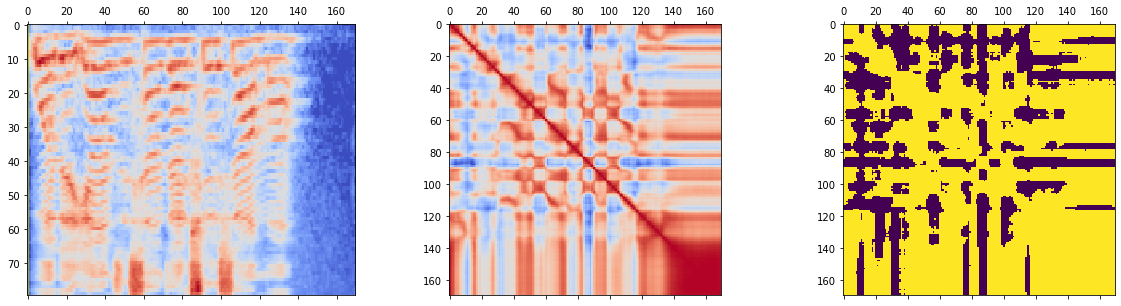

In [23]:
idx = random.randint(0, len(output_mel_paths)-1)
# idx = 125
mel = np.load(output_mel_paths[idx]).T
show_mel_energy(mel)